In [14]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
import random
import matplotlib.pyplot as plt



In [15]:
ExE = pd.read_csv('extracted_data/ExE_imputed.csv', sep=',', index_col=0)
NxN = pd.read_csv('extracted_data/NxN_imputed.csv', sep=',', index_col=0)
ExN = pd.read_csv('extracted_data/ExN_filled.csv', sep=',', index_col=0)

In [16]:
def evaluate_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return r2, rmse

def iterate_over_proportion(data, proportion, models):
    num_columns = max(1, int(data.shape[1] * proportion)) 
    selected_columns = random.sample(data.columns.tolist(), num_columns)

    results = {}

    for model in models:
        model_name = model.__class__.__name__
        r2_scores = []
        rmse_scores = []

        for target_column in selected_columns:
            X = data.drop(columns=[target_column])
            y = data[target_column]

            r2, rmse = evaluate_model(model, X, y)
            r2_scores.append(r2)
            rmse_scores.append(rmse)

        avg_r2 = np.mean(r2_scores)
        avg_rmse = np.mean(rmse_scores)

        results[model_name] = {
            'Average R2': avg_r2,
            'Average RMSE': avg_rmse,
            'r2 array': r2_scores
        }

    return results


def print_results(results):
    for model_name, metrics in results.items():
        print(f"\nModel: {model_name}")
        print(f"Average R²:   {metrics['Average R2']:.4f}")
        print(f"Average RMSE: {metrics['Average RMSE']:.4f}")

        plt.figure(figsize=(8, 4))
        plt.bar(range(len(metrics['r2 array'])), metrics['r2 array'], color='skyblue')
        plt.title(f"R² Values for {model_name}")
        plt.xlabel("Target Column Index")
        plt.ylabel("R² Score")
        plt.ylim(0, 1)
        plt.show()




In [17]:
pca_linear_regression = Pipeline([
    ('pca', PCA(n_components=0.9)), 
    ('linear_regression', LinearRegression())
])
pca_linear_regression.name = 'PCA + Linear Regression'

predictive_models_ExE = [ 
    pca_linear_regression,
    Lasso(alpha=0.0001),
    Ridge(alpha=5)
]

predictive_models_NxN = [ 
    pca_linear_regression,
    Lasso(alpha=0.00005),
    Ridge(alpha=10)
]

predictive_models_ExN = [ 
    pca_linear_regression,
    Lasso(alpha=0.00005),
    Ridge(alpha=10)
]

random.seed(35)
proportion = 0.01

## ExE

Results for ExE:

Model: Pipeline
Average R²:   0.3356
Average RMSE: 0.0556


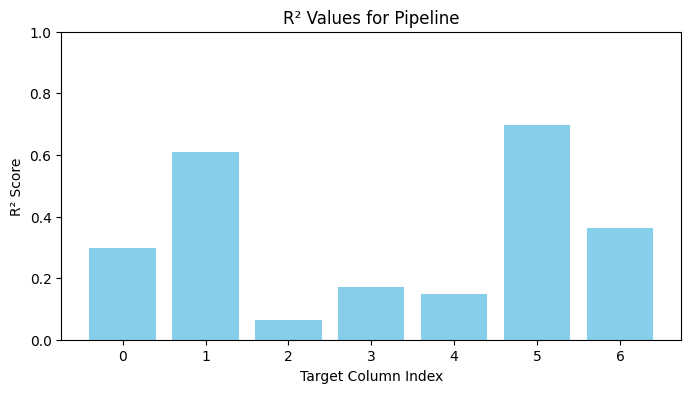


Model: Lasso
Average R²:   0.3816
Average RMSE: 0.0534


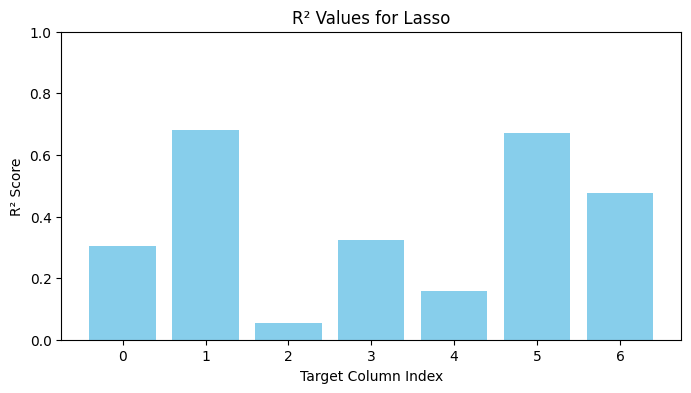


Model: Ridge
Average R²:   0.3943
Average RMSE: 0.0535


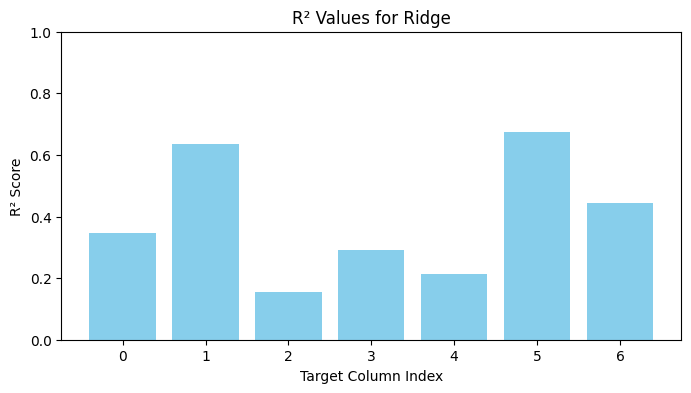

In [18]:
results_ExE = iterate_over_proportion(ExE, proportion, predictive_models_ExE)
print("Results for ExE:")
print_results(results_ExE)

## NxN


Results for NxN:

Model: Pipeline
Average R²:   0.1450
Average RMSE: 0.0386


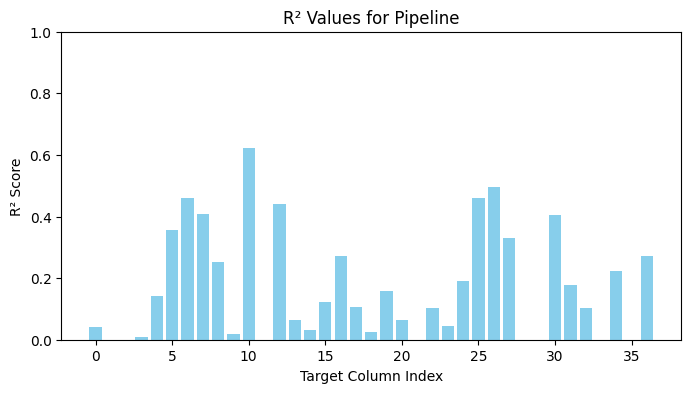


Model: Lasso
Average R²:   0.2732
Average RMSE: 0.0353


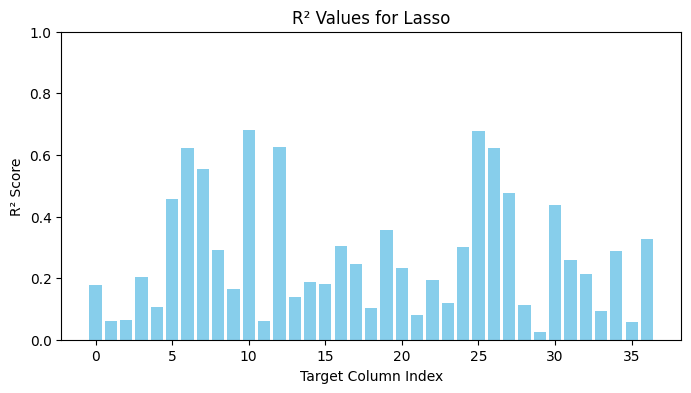


Model: Ridge
Average R²:   0.2548
Average RMSE: 0.0363


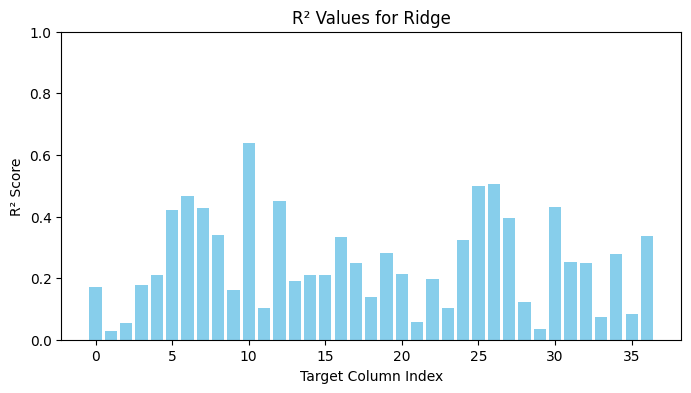

In [19]:
results_NxN = iterate_over_proportion(NxN, proportion, predictive_models_NxN)
print("\nResults for NxN:")
print_results(results_NxN)

## ExN


Results for ExN:

Model: Pipeline
Average R²:   0.4591
Average RMSE: 0.0640


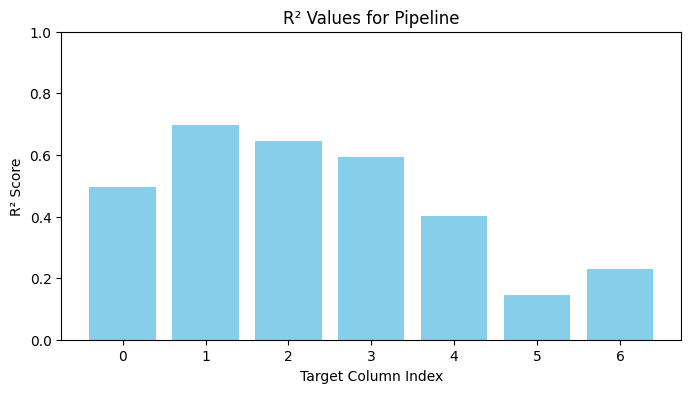


Model: Lasso
Average R²:   0.4234
Average RMSE: 0.0663


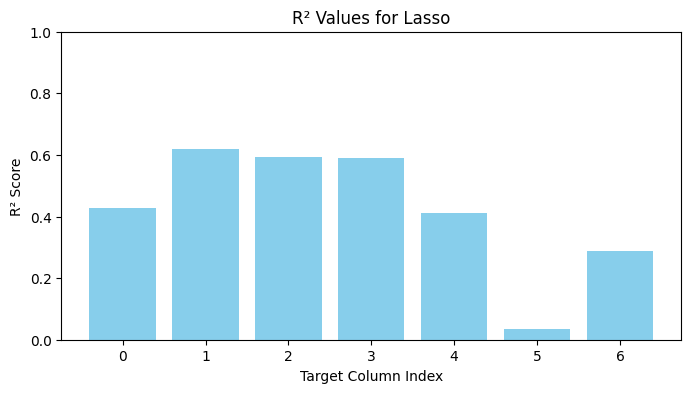


Model: Ridge
Average R²:   0.4713
Average RMSE: 0.0639


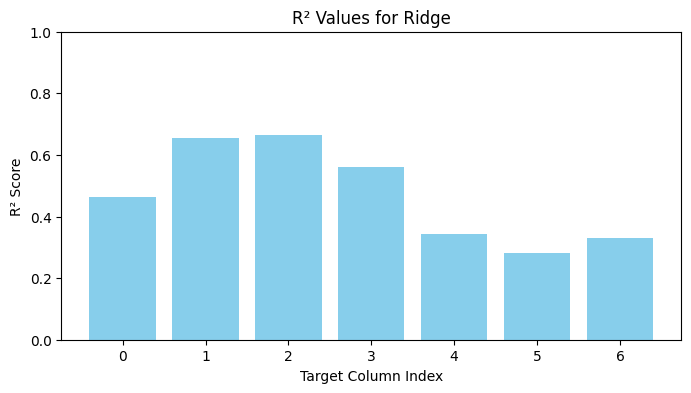

In [20]:
results_ExN = iterate_over_proportion(ExE, proportion, predictive_models_ExN)
print("\nResults for ExN:")
print_results(results_ExN)
